<a href="https://colab.research.google.com/github/anagabyfuentes/ProyectoIntegrador_Mermas/blob/main/Avance3_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install prophet

In [ ]:
pip install torch

In [ ]:
pip install pytorch-lightning pytorch-forecasting

In [ ]:
# Librerías estándar
import math
import warnings
import time

# Data y cómputo numérico
import numpy as np
import pandas as pd
import torch

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Estadística
from scipy.stats import boxcox

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    train_test_split,
    cross_val_score,
)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer, StandardScaler

# Series de tiempo y modelos estadísticos
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# TensorFlow / Keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D, Dense, Flatten, GRU, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# XGBoost
from xgboost import XGBRegressor

# Prophet
from prophet import Prophet

# PyTorch Forecasting & Lightning
from pytorch_forecasting import TimeSeriesDataSet, DeepAR, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning import Trainer


In [ ]:
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Cargar datasets de bodega e isla
df_bod = pd.read_csv("/content/merma_bod_combinado_2022-2024.csv")
df_isla = pd.read_csv("/content/merma_isla_combinado_2022-2024.csv")
df_monterrey = pd.read_csv("/content/monterrey_2022_2024.csv")

# Añadir columna de origen para trazabilidad
df_bod['Origen'] = 'Bodega'
df_isla['Origen'] = 'Isla'

# Unificar ambos datasets
df_merma = pd.concat([df_bod, df_isla], ignore_index=True)

meses = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}

df_merma['Month'] = df_merma['Month'].astype(str).str.strip().str.lower()
df_merma['Month_Num'] = df_merma['Month'].map(meses)
df_merma['Fecha'] = pd.to_datetime(df_merma['Year'].astype(str) + '-' + df_merma['Month_Num'].astype('Int64').astype(str) + '-01', errors='coerce')

# Serie temporal combinada de mermas
df_merma['Fecha'] = pd.to_datetime(df_merma['Fecha'], utc=True)

df_monterrey_reset = df_monterrey.rename(columns={"Unnamed: 0": "Fecha"})
df_monterrey_reset['Fecha'] = pd.to_datetime(df_monterrey_reset['Fecha'], utc=True)

df = df_merma.merge(df_monterrey_reset, on="Fecha", how="left")
df.drop(labels=["Etiqueta", "Tamaño", "Color", "Importe_Venta", "Source", "Month_Num"], axis=1, inplace=True)

og_df = df.copy()
og_df_2 = df.copy()

df

,Year,Month,Producto,Cajas,Kilos,Origen,Fecha,temp_c,pres,gas,humidity,precip,cost_mwh,price_index
0,2024,enero,Cebolla,5,52.5,Bodega,2024-01-01 00:00:00+00:00,14.5,1019,23.5,67.5,21.8,990,158
1,2024,enero,Cebolla,8,80.0,Bodega,2024-01-01 00:00:00+00:00,14.5,1019,23.5,67.5,21.8,990,158
2,2024,enero,Cebolla,0,5.0,Bodega,2024-01-01 00:00:00+00:00,14.5,1019,23.5,67.5,21.8,990,158
3,2024,enero,Cebolla,2,19.0,Bodega,2024-01-01 00:00:00+00:00,14.5,1019,23.5,67.5,21.8,990,158
4,2024,enero,Cebolla,0,19.0,Bodega,2024-01-01 00:00:00+00:00,14.5,1019,23.5,67.5,21.8,990,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,2022,diciembre,Tomate Saladete,32,0.0,Isla,2022-12-01 00:00:00+00:00,13.5,1022,21.3,69.0,22.5,950,139
3437,2022,diciembre,Tomate Saladete,72,0.0,Isla,2022-12-01 00:00:00+00:00,13.5,1022,21.3,69.0,22.5,950,139
3438,2022,diciembre,Tomate Saladete,141,0.0,Isla,2022-12-01 00:00:00+00:00,13.5,1022,21.3,69.0,22.5,950,139
3439,2022,diciembre,Tomate Saladete,2802,0.0,Isla,2022-12-01 00:00:00+00:00,13.5,1022,21.3,69.0,22.5,950,139


In [ ]:
# Verificar porcentaje de nulos en Kilos
porcentaje_kilos_nan = df['Kilos'].isna().mean() * 100
print(f"Porcentaje de valores faltantes en 'Kilos': {porcentaje_kilos_nan:.2f}%")

# Si supera el umbral del 30%, eliminar la variable
if porcentaje_kilos_nan > 30:
    df.drop(columns='Kilos', inplace=True)
    print("La variable 'Kilos' fue eliminada por superar el umbral de valores nulos.")
else:
    print("La variable 'Kilos' se mantiene para análisis.")

# Eliminar 'Importe_Venta' si todos los valores son 0
if 'Importe_Venta' in df.columns and (df['Importe_Venta'] == 0).all():
    df.drop(columns='Importe_Venta', inplace=True)
    print("La variable 'Importe_Venta' fue eliminada por contener solo ceros.")


Porcentaje de valores faltantes en 'Kilos': 0.00%
La variable 'Kilos' se mantiene para análisis.


,Year,Cajas,Kilos,temp_c,pres,gas,humidity,precip,cost_mwh,price_index
count,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000
mean,2023.070619,120.402209,19.816434,22.963034,1012.660854,22.950683,65.871258,54.369253,1125.675676,151.069747
std,0.797496,369.362782,407.874704,6.360366,5.059909,0.996243,4.762734,42.428236,137.534197,16.144832
min,2022.000000,0.000000,0.000000,13.500000,1006.000000,20.900000,49.700000,21.800000,900.000000,120.000000
25%,2022.000000,5.000000,0.000000,16.200000,1008.000000,22.000000,63.700000,29.100000,1000.000000,137.000000
50%,2023.000000,28.000000,0.000000,23.400000,1012.000000,23.000000,65.700000,53.200000,1100.000000,152.000000
75%,2024.000000,90.000000,0.000000,29.500000,1018.000000,23.800000,69.000000,62.600000,1250.000000,165.000000
max,2024.000000,7505.000000,22418.000000,30.800000,1022.000000,24.500000,72.000000,199.700000,1400.000000,178.000000


,Month,Producto,Origen
count,3441,3441,3441
unique,12,24,2
top,junio,Tomate Saladete,Bodega
freq,371,2124,2916


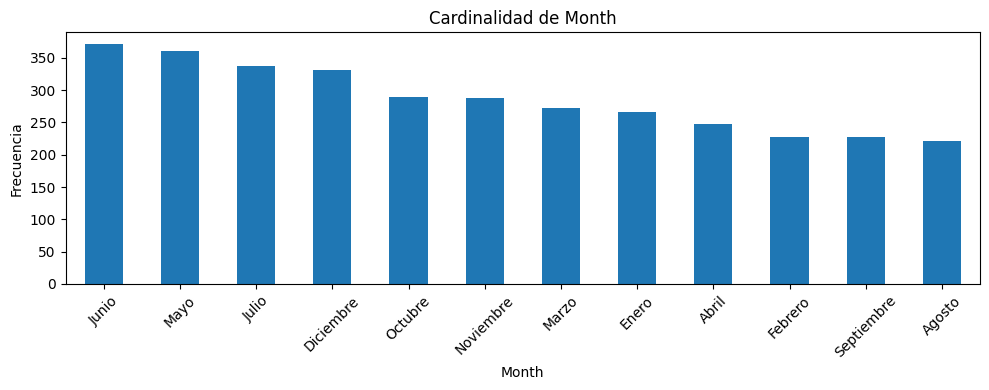

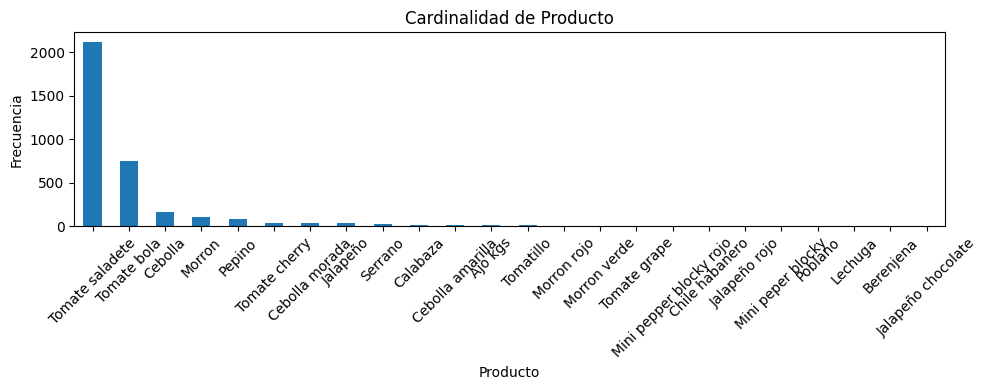

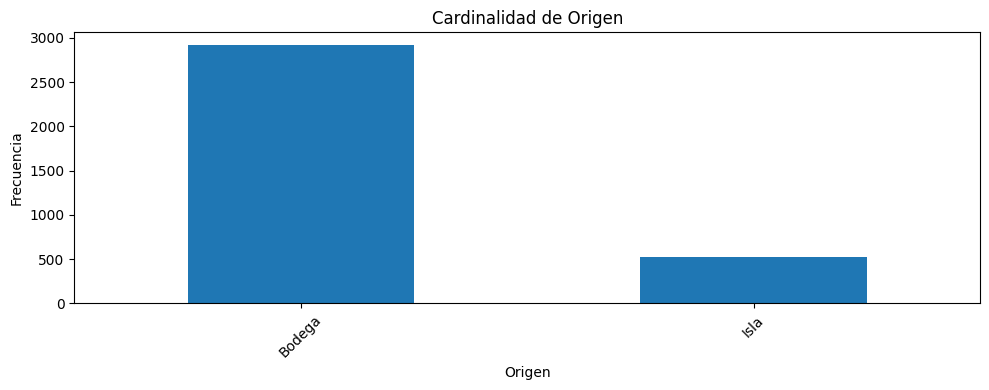

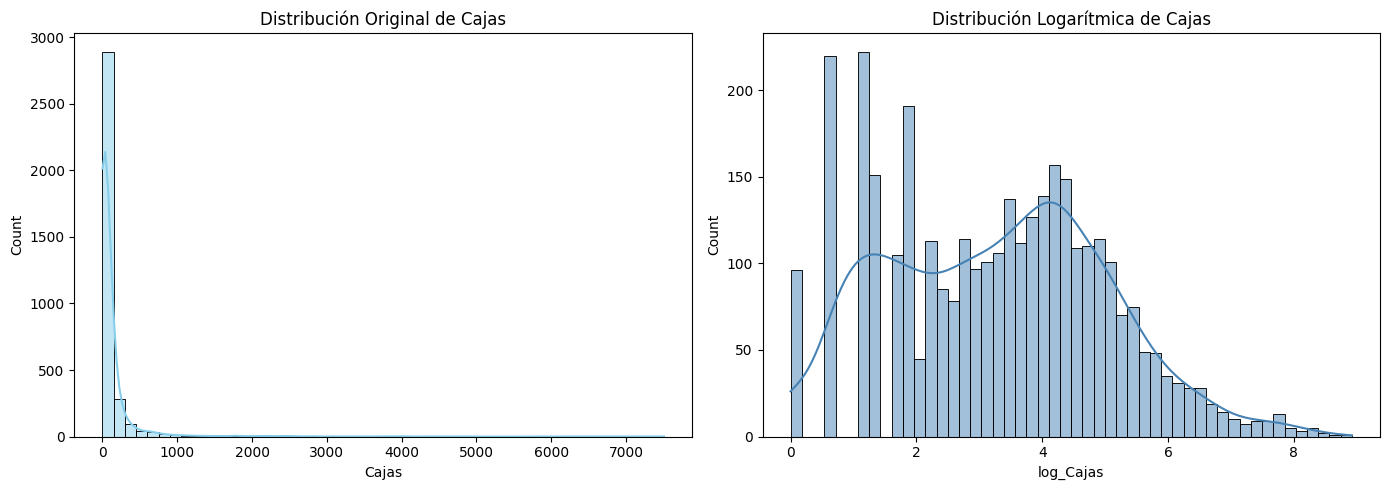

In [ ]:
# Estadísticas descriptivas
display(df.describe())
display(df.describe(include='object'))

# Normalizar texto de variables categóricas para evitar duplicados en la cardinalidad
cat_vars = df.select_dtypes(include='object').columns
for col in cat_vars:
    df[col] = df[col].astype(str).str.strip().str.lower().str.capitalize()

# Visualización de cardinalidad de variables categóricas
for col in cat_vars:
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Cardinalidad de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualización de distribuciones
df['log_Cajas'] = np.log1p(df['Cajas'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Cajas'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución Original de Cajas')

sns.histplot(df['log_Cajas'], bins=50, kde=True, ax=axes[1], color='steelblue')
axes[1].set_title('Distribución Logarítmica de Cajas')

plt.tight_layout()
plt.show()

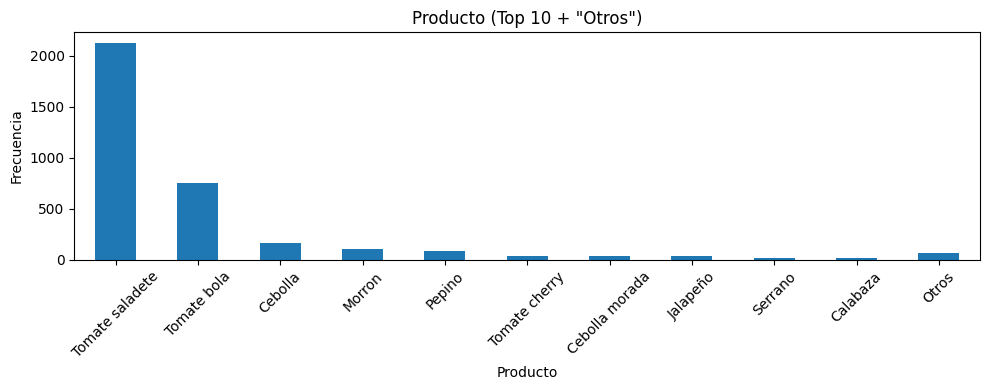

In [ ]:
# Agrupar categorías poco frecuentes en 'Otros' para Producto, Etiqueta y Tamaño y graficar solo top 10 + 'Otros'
for col in ['Producto', 'Etiqueta', 'Tamaño']:
    if col in df.columns:
        top_10 = df[col].value_counts().nlargest(10).index
        df[col] = df[col].apply(lambda x: x if x in top_10 else 'Otros')

        # Recontar después de agrupar
        counts = df[col].value_counts()

        # Reordenar para mostrar top 10 + 'Otros'
        orden = list(top_10) + ['Otros'] if 'Otros' in counts.index else list(top_10)
        counts = counts.reindex(orden)

        # Graficar
        plt.figure(figsize=(10, 4))
        counts.plot(kind='bar')
        plt.title(f'{col} (Top 10 + "Otros")')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

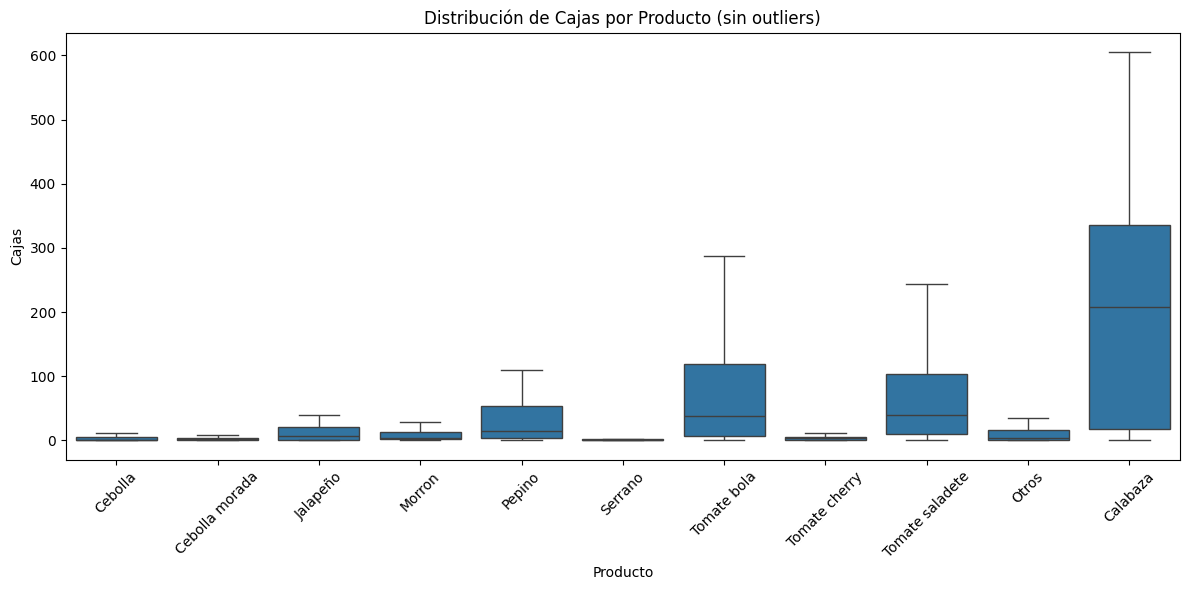

In [ ]:
# Boxplots sin outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas', showfliers=False)
plt.xticks(rotation=45)
plt.title("Distribución de Cajas por Producto (sin outliers)")
plt.tight_layout()
plt.show()

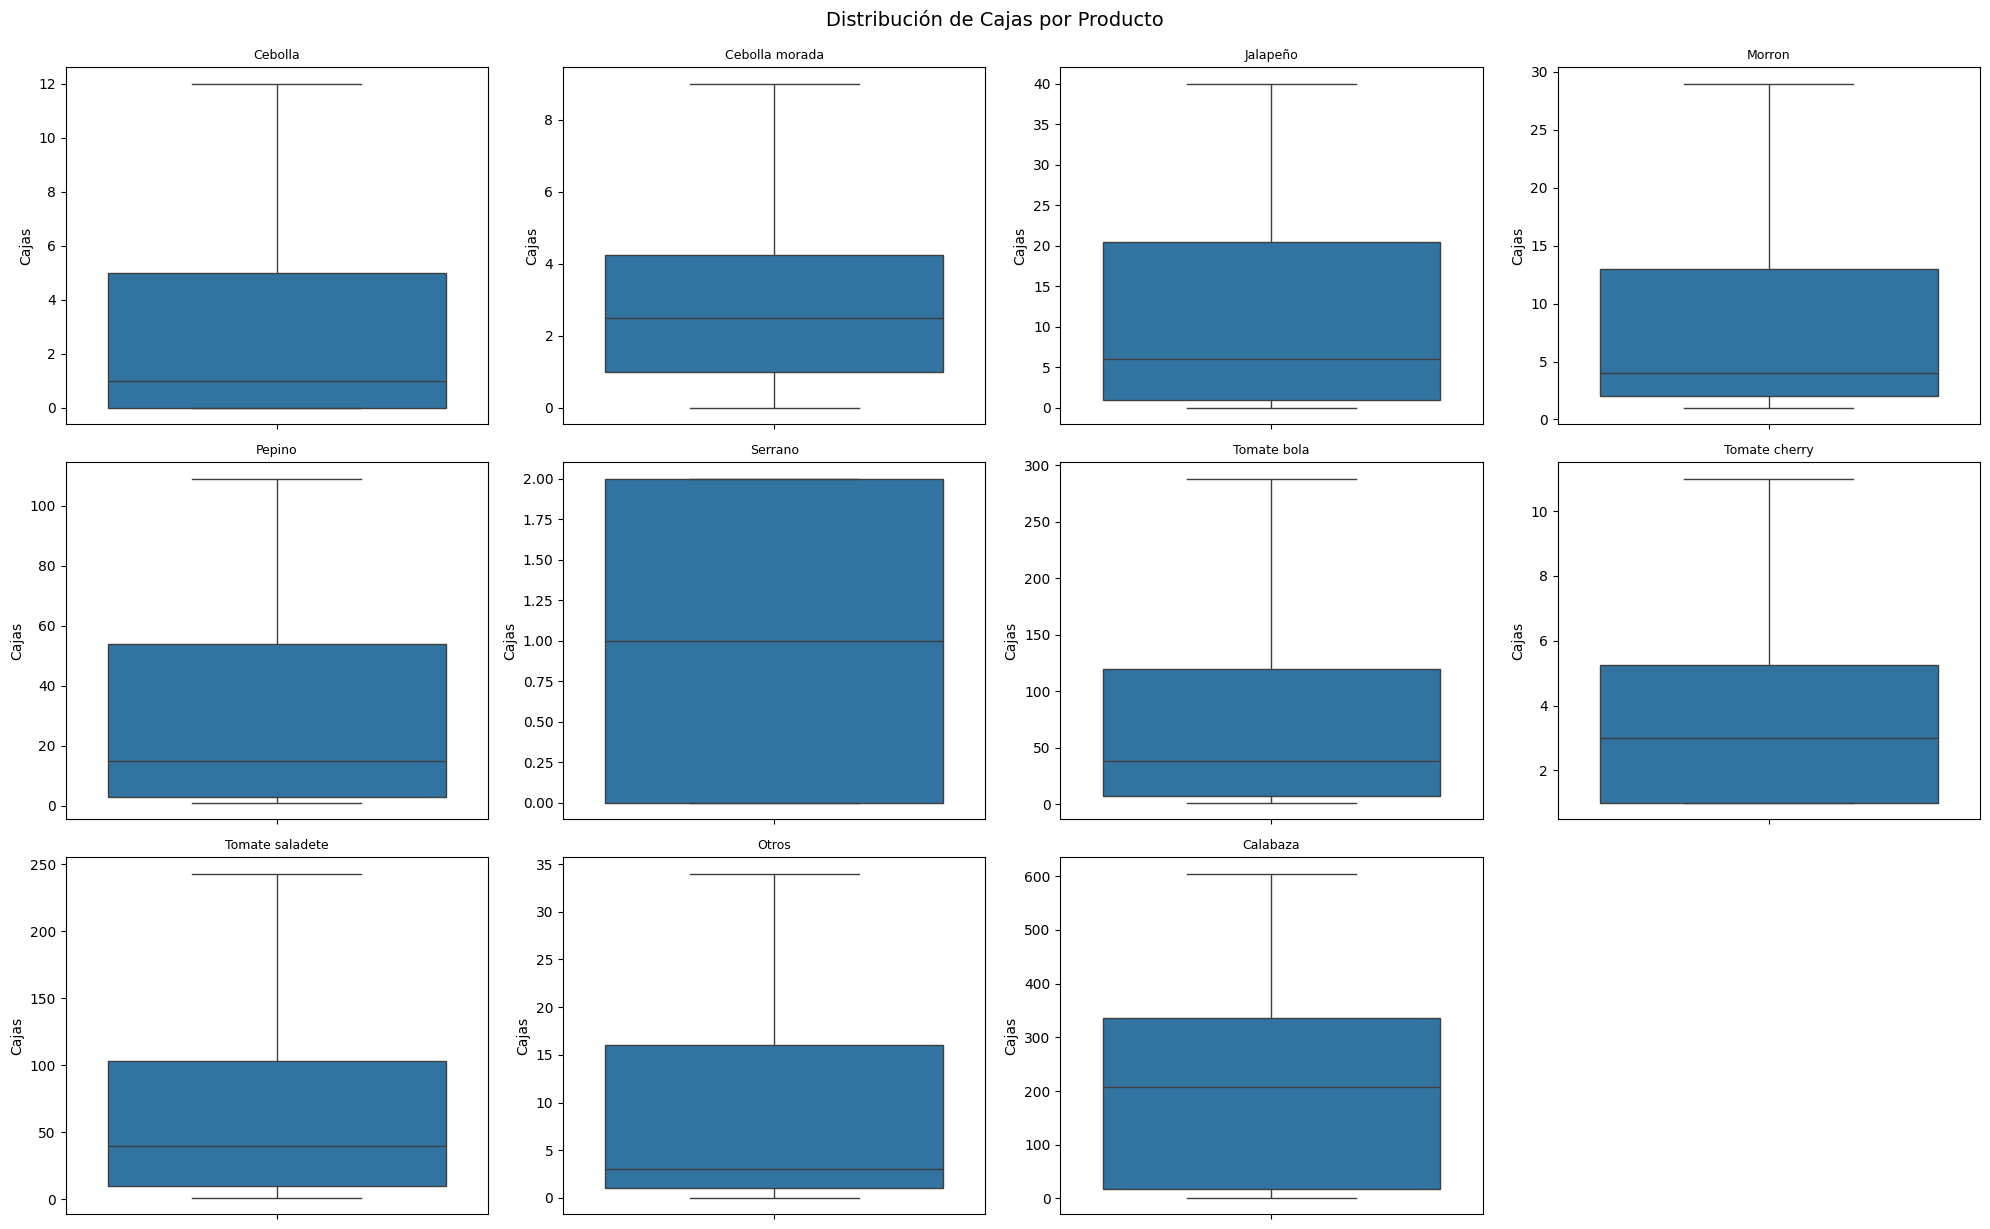

In [ ]:
#En los boxplots de cada producto, usar subgráficas, para que no se exte tanto el análisis.
# Lista de productos únicos
productos = df['Producto'].unique()
n = len(productos)

# 4 columnas por fila
n_cols = 4
n_rows = math.ceil(n / n_cols)

# Crear figura y ejes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Asegura que axes sea un array plano

# Graficar boxplots
for i, producto in enumerate(productos):
    ax = axes[i]
    sns.boxplot(data=df[df['Producto'] == producto], y='Cajas', ax=ax, showfliers=False)
    ax.set_title(f'{producto}', fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('Cajas')

# Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribución de Cajas por Producto", fontsize=14, y=1.02)
plt.show()

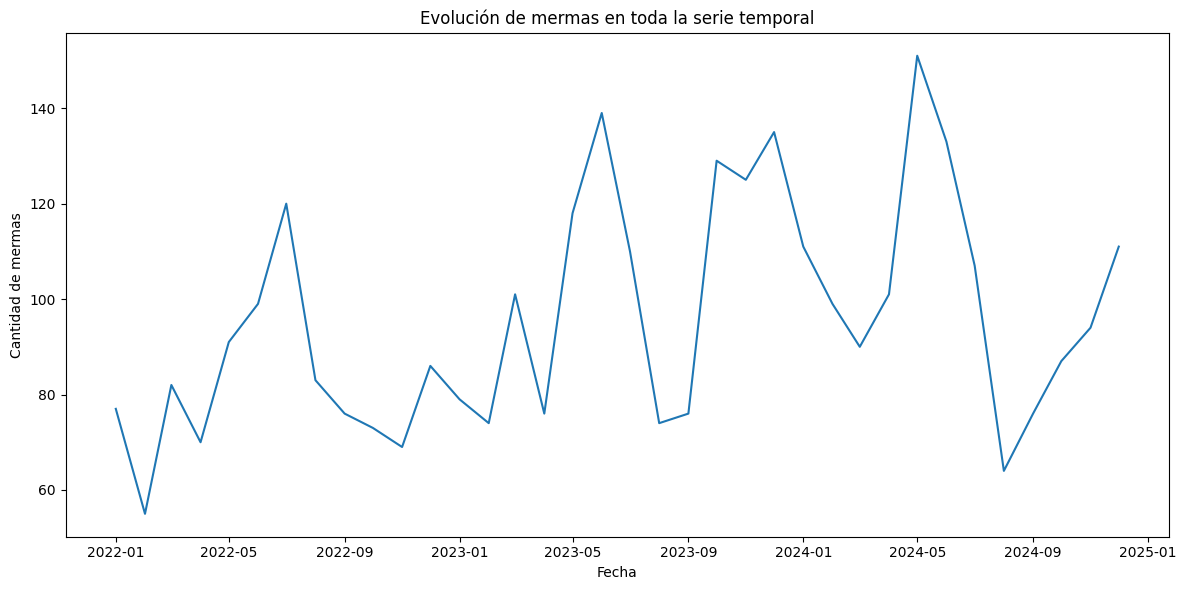

In [ ]:
# Cajas

meses = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}

df['Month'] = df['Month'].astype(str).str.strip().str.lower()
df['Month_Num'] = df['Month'].map(meses)
df['Fecha'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype('Int64').astype(str) + '-01', errors='coerce')

# Serie temporal combinada de mermas
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby('Fecha').size().reset_index(name='Total_Mermas')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='Fecha', y='Total_Mermas')
plt.title('Evolución de mermas en toda la serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de mermas')
plt.tight_layout()
plt.show()


<ipython-input-12-0754fd8bd576>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mermas_por_fecha = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Mermas')


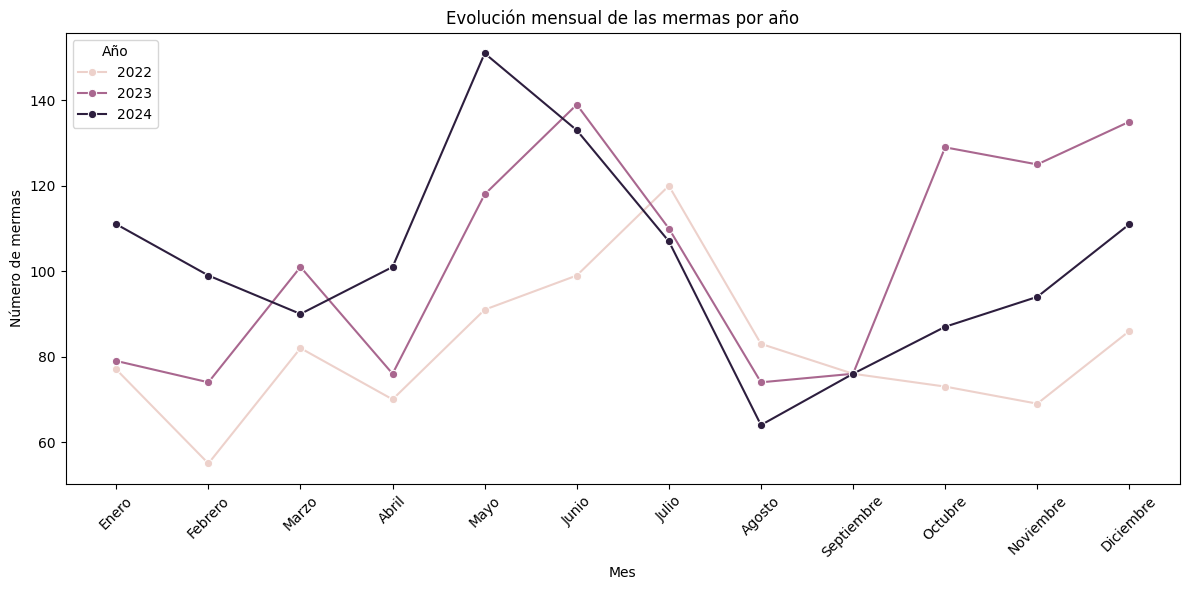

In [ ]:
# La columna "Month" convertirla a númerica:
df['Month'] = df['Month'].astype(str).str.strip().str.capitalize()

meses_ordenados = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
df['Month'] = pd.Categorical(df['Month'], categories=meses_ordenados, ordered=True)

# Agrupar datos por año y mes
mermas_por_fecha = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Mermas')

# Visualización
plt.figure(figsize=(12, 6))
sns.lineplot(data=mermas_por_fecha, x='Month', y='Total_Mermas', hue='Year', marker='o')
plt.title('Evolución mensual de las mermas por año')
plt.xlabel('Mes')
plt.ylabel('Número de mermas')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()


Matriz de correlación:
                 Year     Cajas     Kilos    temp_c      pres       gas  \
Year         1.000000  0.093275  0.015314  0.039904 -0.018196  0.931032   
Cajas        0.093275  1.000000  0.048632  0.060904 -0.050823  0.107671   
Kilos        0.015314  0.048632  1.000000  0.010346 -0.012908  0.012514   
temp_c       0.039904  0.060904  0.010346  1.000000 -0.975142  0.361068   
pres        -0.018196 -0.050823 -0.012908 -0.975142  1.000000 -0.321369   
gas          0.931032  0.107671  0.012514  0.361068 -0.321369  1.000000   
humidity     0.260399 -0.006532 -0.002939 -0.209982  0.280489  0.202831   
precip      -0.039731  0.009728  0.001401  0.494701 -0.459442  0.109176   
cost_mwh     0.021841  0.066656  0.014056  0.891027 -0.910392  0.287546   
price_index  0.938804  0.107047  0.010946  0.082506  0.000831  0.910069   
log_Cajas    0.146355  0.549400  0.031833  0.094596 -0.079881  0.173323   
Month_Num   -0.038818  0.043637 -0.011420 -0.014315  0.195292  0.026188   

 

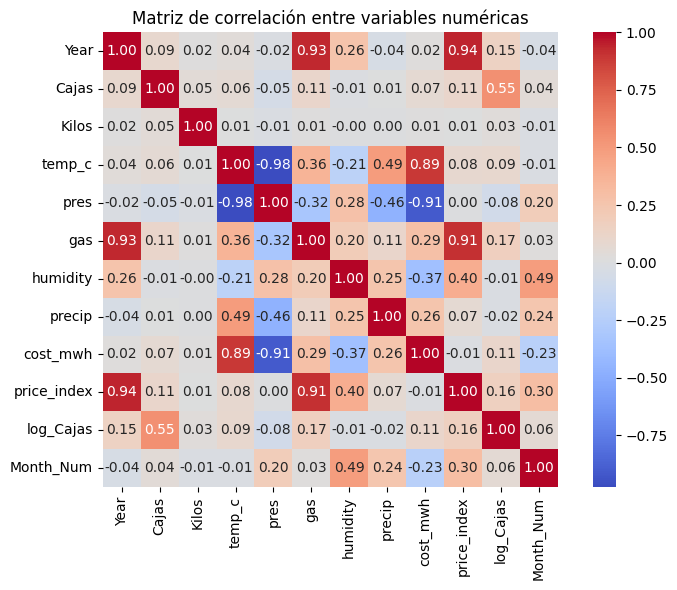

In [ ]:
# Seleccionar solo las columnas numéricas
df_numericas = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
matriz_corr = df_numericas.corr()

# Mostrar la matriz de correlación
print("Matriz de correlación:")
print(matriz_corr)

# Visualización con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de correlación entre variables numéricas')
plt.tight_layout()
plt.show()

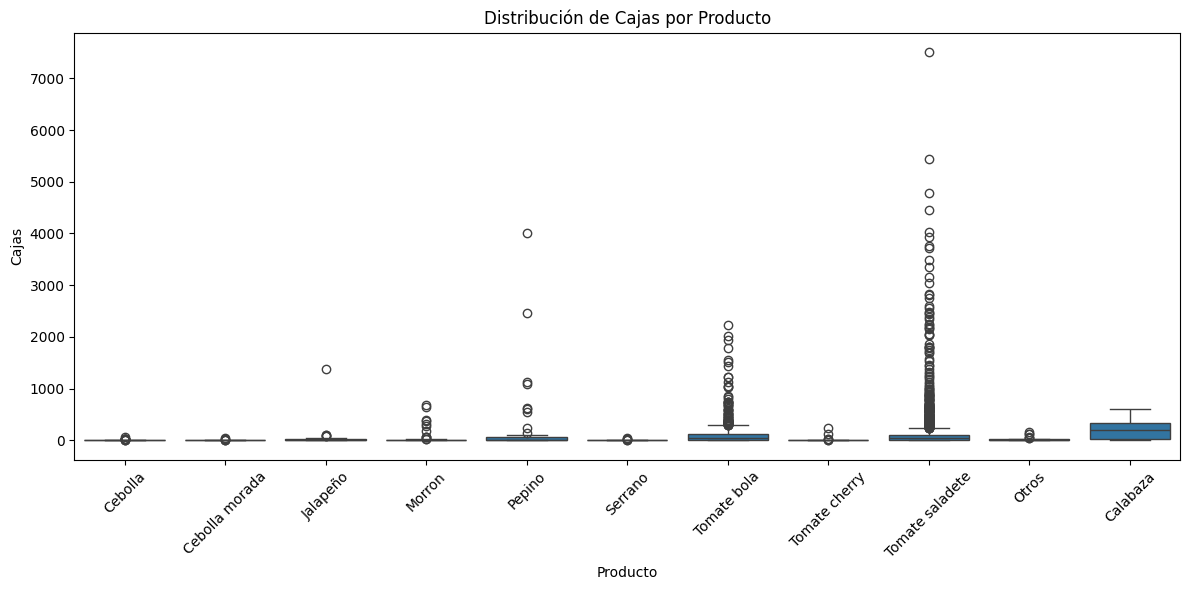

In [ ]:
#Analisis Bi variado

# Análisis bivariado: Producto vs Cajas (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas')
plt.xticks(rotation=45)
plt.title("Distribución de Cajas por Producto")
plt.tight_layout()
plt.show()


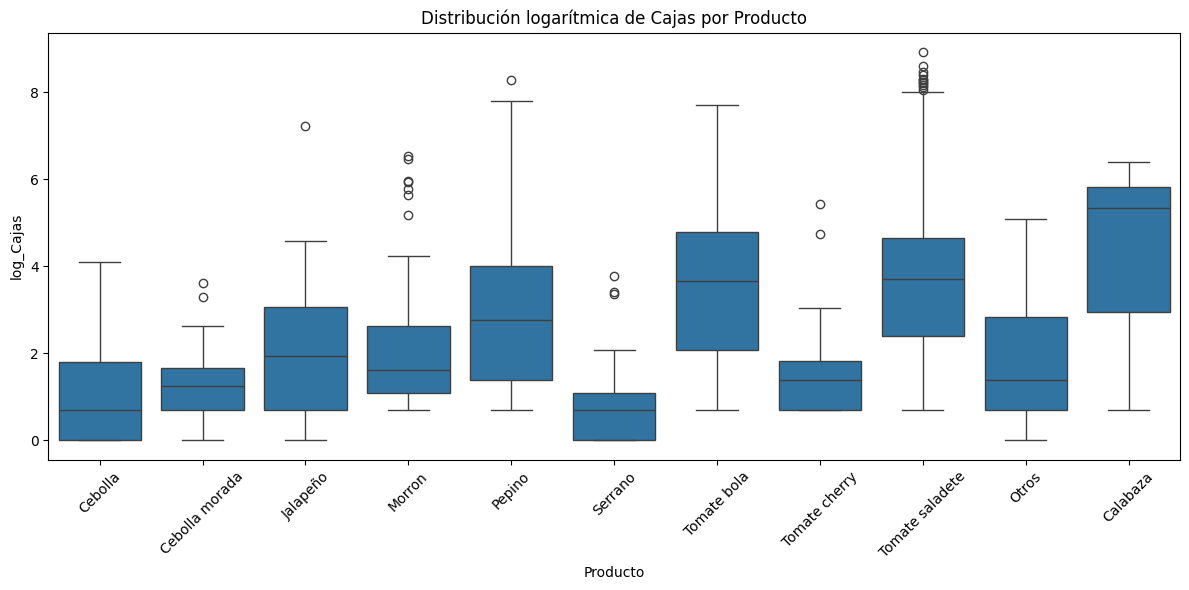

In [ ]:
# Transformación logarítmica de Cajas
df['log_Cajas'] = np.log1p(df['Cajas'])

# log_Cajas vs Producto
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='log_Cajas')
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()

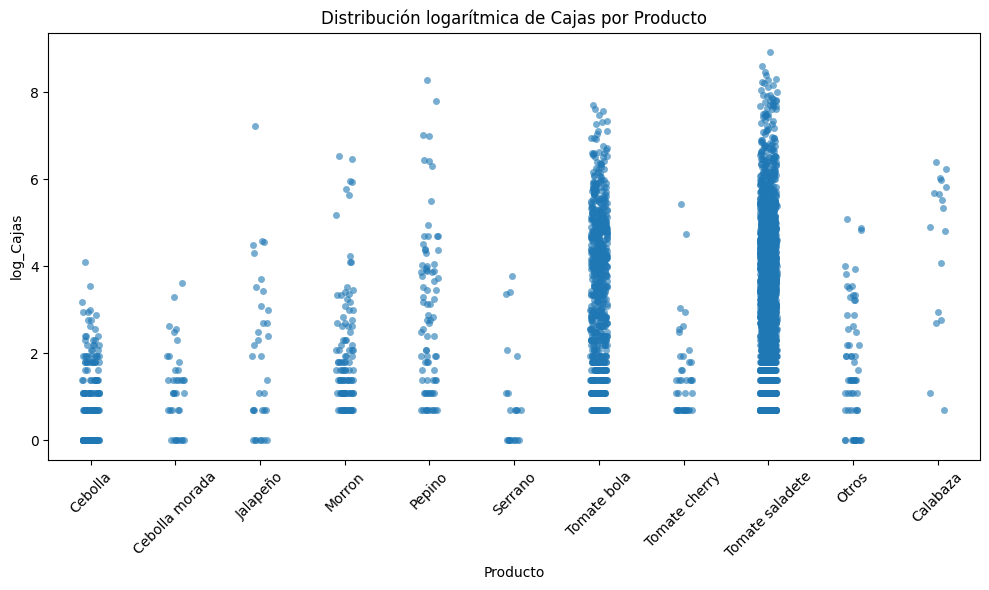

In [ ]:
# Análisis con variable transformada (logarítmica)
df['log_Cajas'] = np.log1p(df['Cajas'])

# log_Cajas vs Producto (scatterplot codificado por producto)
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Producto', y='log_Cajas', alpha=0.6, jitter=True)
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# TRANSFORMACION
# -------------------------------

# -------------------------------
# Codificación One-Hot de variables categóricas
# -------------------------------
# Seleccionar variable
cat_column = 'Producto'

# Aplicar codificación one-hot
df_encoded = pd.get_dummies(df, columns=[cat_column], prefix=cat_column)

# Mostrar columnas resultantes
print(f"Columnas después de one-hot encoding de '{cat_column}':")
print([col for col in df_encoded.columns if cat_column in col])

# -------------------------------
# Escalamiento Min-Max de variable numérica
# -------------------------------
scaler = MinMaxScaler()
df_encoded['Cajas_minmax'] = scaler.fit_transform(df_encoded[['Cajas']])

print("\nEscalado Min-Max en 'Cajas':")
print(df_encoded[['Cajas', 'Cajas_minmax']].head())

# -------------------------------
# Transformación logarítmica
# -------------------------------
df_encoded['Cajas_log'] = np.log1p(df_encoded['Cajas'])

print("\nTransformación logarítmica en 'Cajas':")
print(df_encoded[['Cajas', 'Cajas_log']].head())


Columnas después de one-hot encoding de 'Producto':
['Producto_Calabaza', 'Producto_Cebolla', 'Producto_Cebolla morada', 'Producto_Jalapeño', 'Producto_Morron', 'Producto_Otros', 'Producto_Pepino', 'Producto_Serrano', 'Producto_Tomate bola', 'Producto_Tomate cherry', 'Producto_Tomate saladete']

Escalado Min-Max en 'Cajas':
   Cajas  Cajas_minmax
0      5      0.000666
1      8      0.001066
2      0      0.000000
3      2      0.000266
4      0      0.000000

Transformación logarítmica en 'Cajas':
   Cajas  Cajas_log
0      5   1.791759
1      8   2.197225
2      0   0.000000
3      2   1.098612
4      0   0.000000


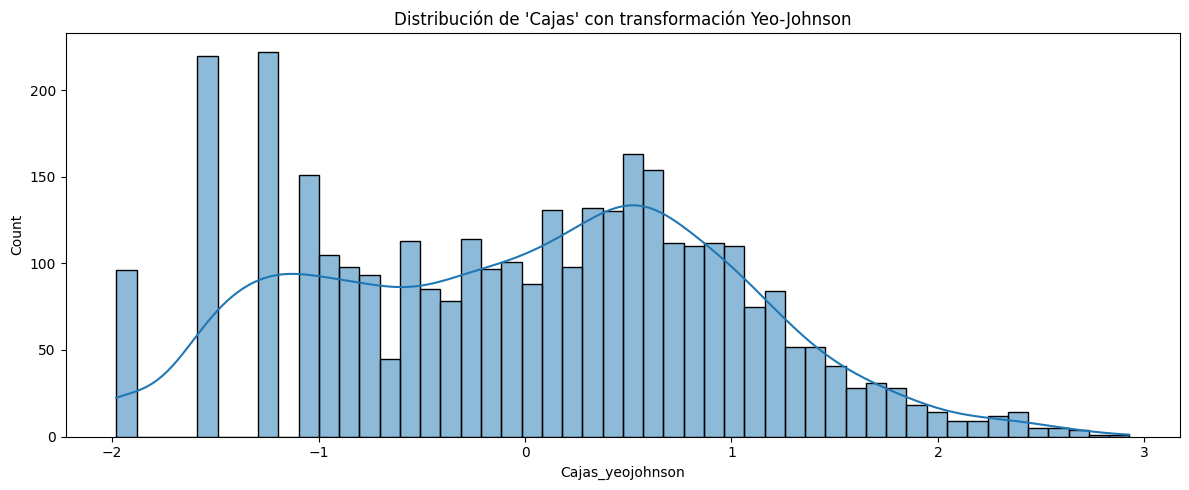

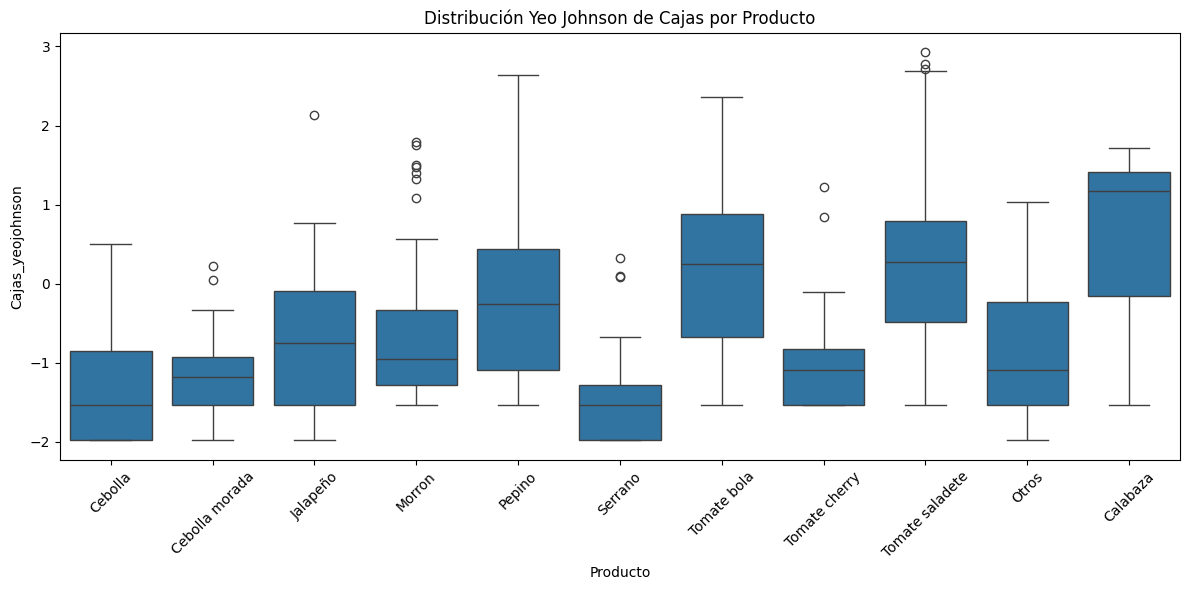

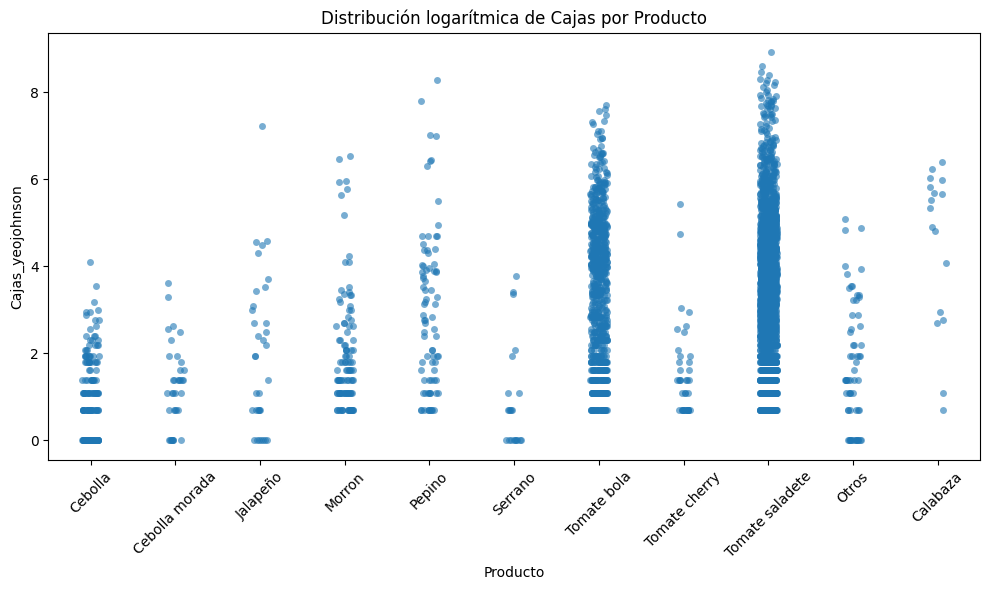

In [ ]:
# Aplicar transformación Yeo-Johnson (admite ceros y negativos)
pt = PowerTransformer(method='yeo-johnson')
df['Cajas_yeojohnson'] = pt.fit_transform(df[['Cajas']])

# Visualizar distribución transformada
plt.figure(figsize=(12, 5))
sns.histplot(df['Cajas_yeojohnson'], bins=50, kde=True)
plt.title("Distribución de 'Cajas' con transformación Yeo-Johnson")
plt.tight_layout()
plt.show()

# Cajas_yeojohnson vs Producto
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Producto', y='Cajas_yeojohnson')
plt.xticks(rotation=45)
plt.title("Distribución Yeo Johnson de Cajas por Producto")
plt.tight_layout()
plt.show()

# Análisis con variable transformada (logarítmica)
import numpy as np
df['Cajas_yeojohnson'] = np.log1p(df['Cajas'])

# Cajas_yeojohnson vs Producto (scatterplot codificado por producto)
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Producto', y='Cajas_yeojohnson', alpha=0.6, jitter=True)
plt.xticks(rotation=45)
plt.title("Distribución logarítmica de Cajas por Producto")
plt.tight_layout()
plt.show()


### Justificación de los métodos ejecutados

Durante la fase de preparación de los datos, se aplicaron diversas transformaciones y técnicas fundamentadas en criterios de **calidad**, **interpretabilidad** y **robustez** para el aprendizaje automático. A continuación, se justifica cada una:

#### 1. **Codificación One-Hot**
- Se utilizó `One-Hot Encoding` sobre variables categóricas como `Producto`, `Etiqueta` y `Tamaño`, ya que no poseen un orden natural.
- Esta técnica evita introducir relaciones artificiales de jerarquía entre categorías.
- Es compatible con modelos como regresiones, árboles de decisión y redes neuronales.

#### 2. **Normalización de categorías**
- Se aplicaron técnicas de limpieza de texto para estandarizar variables como `Origen` y `Month`, eliminando inconsistencias por mayúsculas, espacios o tildes.
- Además, se agruparon las categorías poco frecuentes en una clase `"Otros"` para reducir la cardinalidad y evitar el sobreajuste.

#### 3. **Tratamiento de valores atípicos**
- Se detectaron outliers en la variable `Cajas` usando el método del rango intercuartílico (IQR).
- Su visualización en la dimensión temporal permitió tomar decisiones informadas sobre su imputación o ajuste.

#### 4. **Transformación Yeo-Johnson**
- Se exploró la transformación `Yeo-Johnson` para evaluar su efecto en la simetría de la distribución de `Cajas`.
- Aunque útil para modelos sensibles a la normalidad, **no fue utilizada en la variable objetivo final**, dado que se privilegió mantenerla en unidades reales para facilitar su interpretación.

> Estas decisiones permitieron construir un conjunto de datos limpio, balanceado y trazable, adecuado para su uso en modelos de aprendizaje automático como Random Forest, XGBoost y otros algoritmos robustos a la escala.

### La fase de preparación de los datos dentro del ciclo **CRISP-ML** se ejecutó siguiendo criterios de **calidad**, **eficiencia** y **trazabilidad**, sentando una base robusta para el modelado posterior. A continuación, se detallan los principales logros y decisiones justificadas:

- **Limpieza estructurada** de los datos crudos, incluyendo la eliminación de variables con más del 30% de valores faltantes.
- **Imputación de valores faltantes restantes** mediante ceros, tras evaluar su impacto relativo por variable.
- **Generación de variables temporales derivadas** (`Año`, `Mes`, `Trimestre`, `Día de semana`, `Es_fin_de_semana`) a partir de la columna `Fecha`, lo que facilita análisis estacionales y series de tiempo.
- **Identificación y tratamiento de valores atípicos** mediante el método del rango intercuartílico (IQR), con visualización temporal para contexto y validación.
- **Codificación one-hot** de variables categóricas nominales como `Producto`, `Etiqueta` y `Tamaño`, incluyendo agrupamiento de categorías infrecuentes en `"Otros"` para controlar la cardinalidad.
- **Normalización de texto en variables categóricas**, estandarizando mayúsculas, espacios y formato para evitar duplicación artificial de categorías (`Origen`, `Month`, etc.).

Estas acciones permitieron construir un conjunto de datos **limpio, consistente y confiable**, adecuado para la siguiente fase del ciclo: **modelado, validación y despliegue**.

Toda transformación ha sido cuidadosamente documentada en este cuaderno, garantizando la **reproducibilidad** y facilitando el mantenimiento del pipeline analítico.

       Fecha  Anio  Mes  Trimestre  Semana  Dia_Semana  Es_fin_de_semana
0 2024-01-01  2024    1          1       1           0             False
1 2024-01-01  2024    1          1       1           0             False
2 2024-01-01  2024    1          1       1           0             False
3 2024-01-01  2024    1          1       1           0             False
4 2024-01-01  2024    1          1       1           0             False


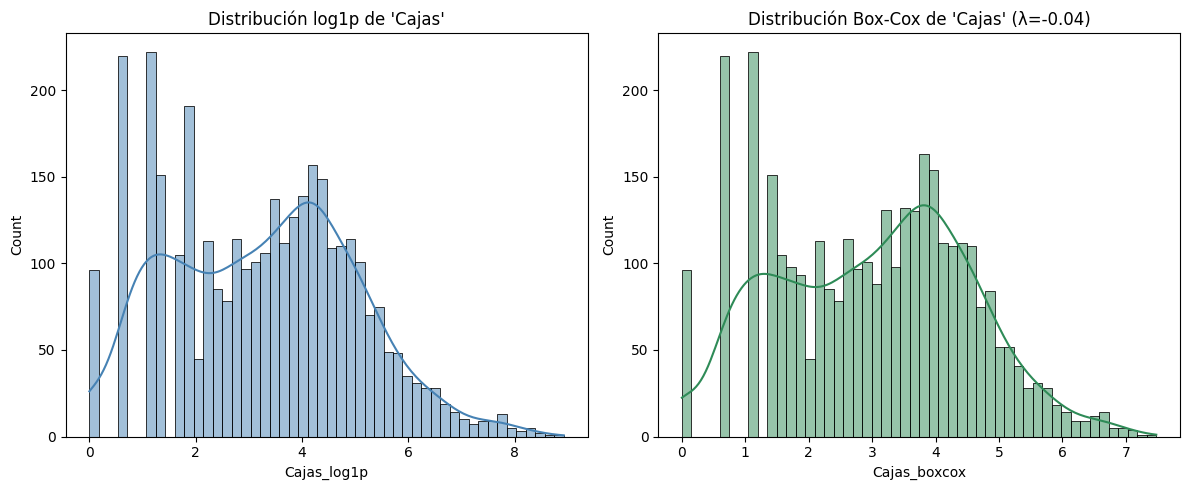

In [ ]:
# -------------------------------
# GENERACIÓN DE NUEVAS CARACTERÍSTICAS TEMPORALES Y TRANSFORMACIÓN BOX-COX
# -------------------------------
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Generar nuevas características temporales
df['Anio'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Trimestre'] = df['Fecha'].dt.quarter
df['Semana'] = df['Fecha'].dt.isocalendar().week
df['Dia_Semana'] = df['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['Es_fin_de_semana'] = df['Dia_Semana'].isin([5, 6])

print(df[['Fecha', 'Anio', 'Mes', 'Trimestre', 'Semana', 'Dia_Semana', 'Es_fin_de_semana']].head())

# -------------------------------
# Comparativa: log1p vs Box-Cox en 'Cajas'
# -------------------------------

# Preparar variable positiva para Box-Cox
cajas_positiva = df['Cajas'] + 1

# Aplicar Box-Cox
cajas_boxcox, lambda_bc = boxcox(cajas_positiva)

# Agregar al DataFrame
df['Cajas_log1p'] = np.log1p(df['Cajas'])
df['Cajas_boxcox'] = cajas_boxcox

# Visualizar comparativa de distribuciones
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Cajas_log1p'], bins=50, kde=True, color='steelblue')
plt.title("Distribución log1p de 'Cajas'")

plt.subplot(1, 2, 2)
sns.histplot(df['Cajas_boxcox'], bins=50, kde=True, color='seagreen')
plt.title(f"Distribución Box-Cox de 'Cajas' (λ={lambda_bc:.2f})")

plt.tight_layout()
plt.show()


       Fecha  Anio  Mes  Trimestre  Semana  Dia_Semana  Es_fin_de_semana
0 2024-01-01  2024    1          1       1           0             False
1 2024-01-01  2024    1          1       1           0             False
2 2024-01-01  2024    1          1       1           0             False
3 2024-01-01  2024    1          1       1           0             False
4 2024-01-01  2024    1          1       1           0             False


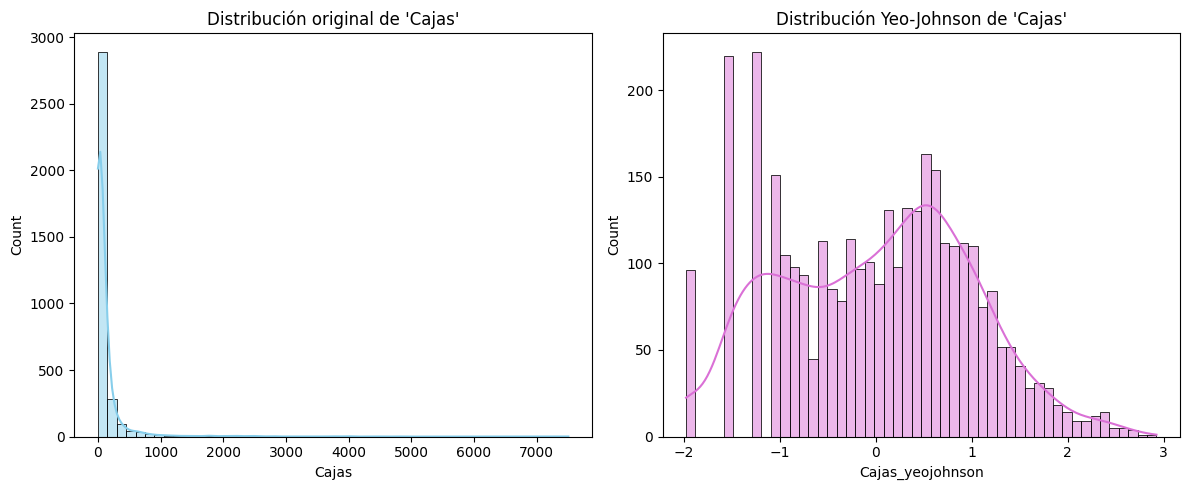

In [ ]:
# -------------------------------
# GENERACIÓN DE NUEVAS CARACTERÍSTICAS TEMPORALES YEO JOHNSON
# -------------------------------
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Generar variables temporales
df['Anio'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Trimestre'] = df['Fecha'].dt.quarter
df['Semana'] = df['Fecha'].dt.isocalendar().week
df['Dia_Semana'] = df['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['Es_fin_de_semana'] = df['Dia_Semana'].isin([5, 6])

print(df[['Fecha', 'Anio', 'Mes', 'Trimestre', 'Semana', 'Dia_Semana', 'Es_fin_de_semana']].head())

# -------------------------------
# Transformación Yeo-Johnson en 'Cajas'
# -------------------------------
pt = PowerTransformer(method='yeo-johnson')
df['Cajas_yeojohnson'] = pt.fit_transform(df[['Cajas']])

# Visualización de la distribución original y transformada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Cajas'], bins=50, kde=True, color='skyblue')
plt.title("Distribución original de 'Cajas'")

plt.subplot(1, 2, 2)
sns.histplot(df['Cajas_yeojohnson'], bins=50, kde=True, color='orchid')
plt.title("Distribución Yeo-Johnson de 'Cajas'")

plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------
# MODELO BASE DE REGRESIÓN LINEAL (BASELINE)
# -------------------------------
# Crear una copia limpia del DataFrame
df_model = og_df_2.copy()

# Eliminar columnas datetime
dt_cols = df_model.columns[df_model.dtypes.apply(pd.api.types.is_datetime64_any_dtype)]
df_model = df_model.drop(columns=dt_cols)

# Convertir columnas categóricas a string de forma segura
for col in df_model.select_dtypes(include=['category', 'object', 'bool']).columns:
    df_model[col] = df_model[col].astype(str).str.strip().str.lower().str.capitalize()

# Confirmar columnas no numéricas antes de codificar
non_numeric = df_model.select_dtypes(exclude=['number']).columns
print("Columnas no numéricas antes del encoding:", list(non_numeric))

# Codificación con get_dummies
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Definir X e y
X = df_encoded.drop(columns=['Cajas'], errors='ignore')
y = df_encoded['Cajas']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base
modelo_base = LinearRegression()
modelo_base.fit(X_train, y_train)

# Predicción y métricas
y_pred = modelo_base.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # cambio aquí
r2 = r2_score(y_test, y_pred)

# Resultados
print("Evaluación del modelo base (Regresión Lineal):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


Columnas no numéricas antes del encoding: ['Month', 'Producto', 'Origen']
Evaluación del modelo base (Regresión Lineal):
MAE  = 133.86
RMSE = 291.09
R²   = 0.089


In [ ]:

# -------------------------------
# COMPARACIÓN: RANDOM FOREST REGRESSOR
# -------------------------------

# Entrenar modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)  # FALTABA ESTA LÍNEA
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print("Evaluación del modelo Random Forest:")
print(f"MAE  = {mae_rf:.2f}")
print(f"RMSE = {rmse_rf:.2f}")
print(f"R²   = {r2_rf:.3f}")



Evaluación del modelo Random Forest:
MAE  = 128.44
RMSE = 306.81
R²   = -0.012


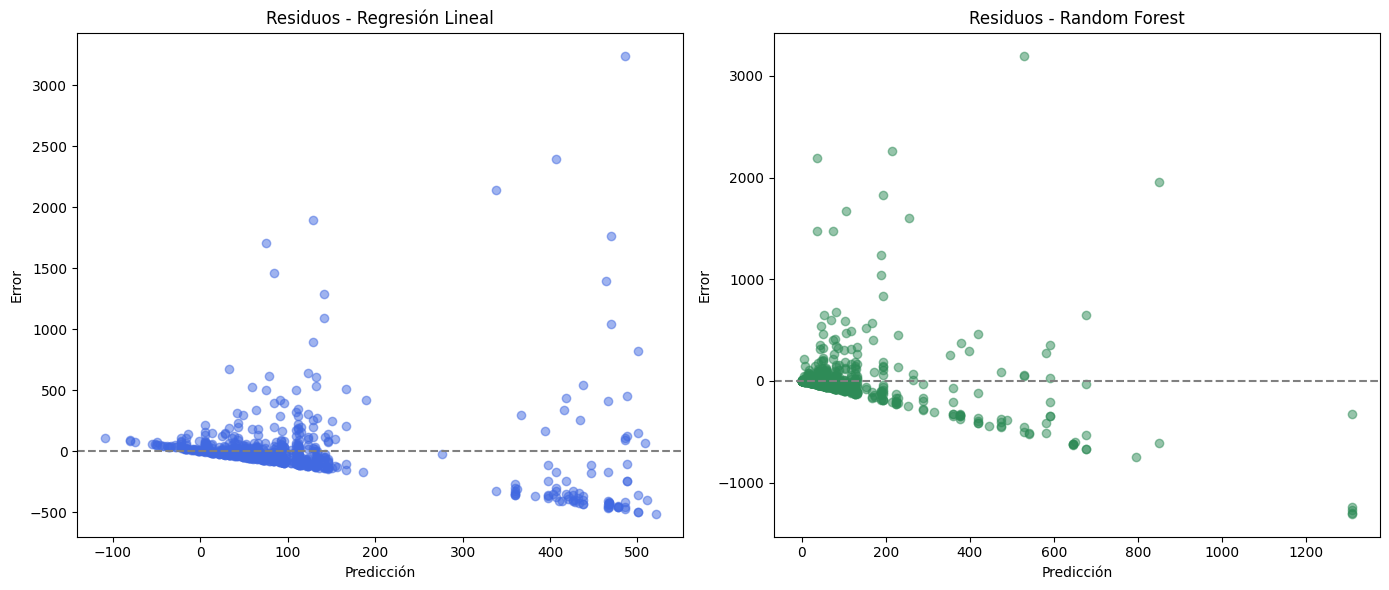

In [ ]:
# -------------------------------
# VISUALIZACIÓN DE RESIDUOS DE LOS MODELOS
# -------------------------------

# Calcular residuos
residuos_lr = y_test - y_pred
residuos_rf = y_test - y_pred_rf

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuos_lr, alpha=0.5, color='royalblue')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuos - Regresión Lineal')
plt.xlabel('Predicción')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_rf, residuos_rf, alpha=0.5, color='seagreen')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuos - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

Resumen de residuos - Regresión Lineal:
count     689.000000
mean       -0.012028
std       291.302016
min      -513.690043
25%       -81.695420
50%       -26.308780
75%        27.363188
max      3240.743403
Name: Cajas, dtype: float64

Resumen de residuos - Random Forest:
count     689.000000
mean       -0.455121
std       307.028825
min     -1307.259603
25%       -63.771194
50%       -14.838833
75%        15.852655
max      3197.925944
Name: Cajas, dtype: float64


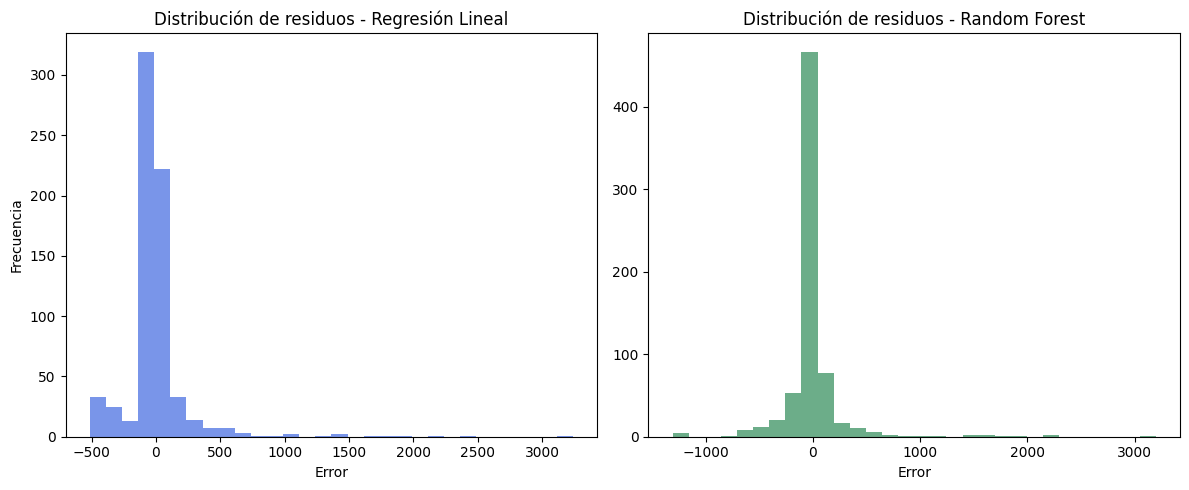

In [ ]:
# Calcular residuos
residuos_lr = y_test - y_pred
residuos_rf = y_test - y_pred_rf

# Estadísticas básicas
print("Resumen de residuos - Regresión Lineal:")
print(residuos_lr.describe())

print("\nResumen de residuos - Random Forest:")
print(residuos_rf.describe())

# Histograma de errores

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuos_lr, bins=30, color='royalblue', alpha=0.7)
plt.title('Distribución de residuos - Regresión Lineal')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(residuos_rf, bins=30, color='seagreen', alpha=0.7)
plt.title('Distribución de residuos - Random Forest')
plt.xlabel('Error')
plt.tight_layout()
plt.show()


In [ ]:
# Evaluación con R² en 5 particiones
scores = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')
print("R² promedio (5-fold CV):", np.mean(scores))


R² promedio (5-fold CV): -0.009355725543978056


 Análisis del Modelo Predictivo - Regresión Lineal & Random Forest

##Conclusión
Después de resolver el Data Leakage se concluyó que ninguno de los dos modelos, excluyendo la variable temporal, son eficientes para predecir la variable de salida.


<ipython-input-29-b530a5a8025a>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cajas_mensual = df.set_index('Fecha')['Cajas'].resample('M').sum()


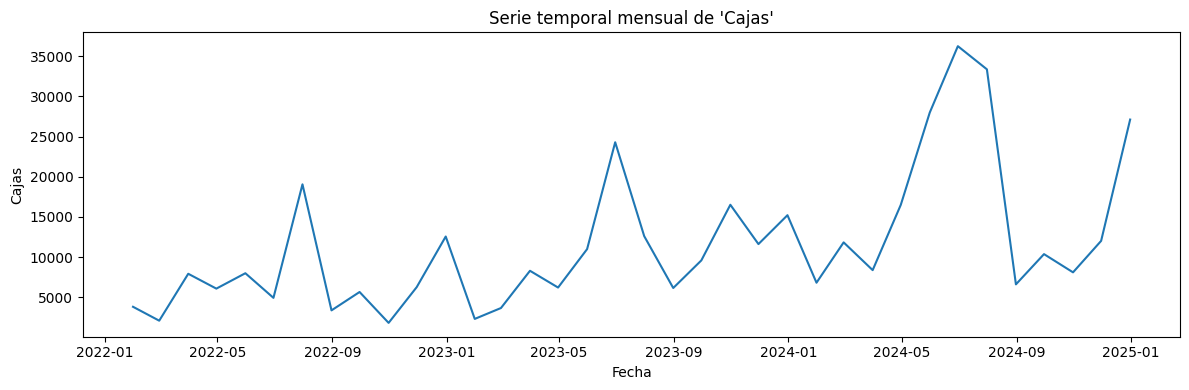

### Prueba ADF sobre 'Cajas' mensual:
ADF Statistic: -3.1050
p-value: 0.0262
Valores críticos:
   1%: -3.6327
   5%: -2.9485
   10%: -2.6130
Resultado: Estacionaria



<ipython-input-29-b530a5a8025a>:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cajas_yeo_mensual = df.set_index('Fecha')['Cajas_yeojohnson'].resample('M').mean()


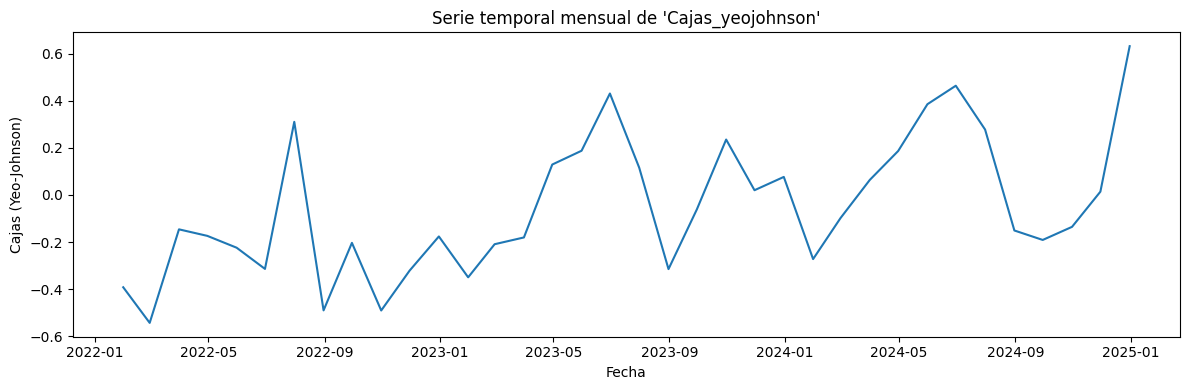

### Prueba ADF sobre 'Cajas_yeojohnson' mensual:
ADF Statistic: -2.7438
p-value: 0.0668
Valores críticos:
   1%: -3.6392
   5%: -2.9512
   10%: -2.6144
Resultado: No estacionaria


In [ ]:
# Asegurar formato y orden
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha')

# Serie mensual de Cajas original
cajas_mensual = df.set_index('Fecha')['Cajas'].resample('M').sum()

# Visualización
plt.figure(figsize=(12, 4))
sns.lineplot(data=cajas_mensual)
plt.title("Serie temporal mensual de 'Cajas'")
plt.ylabel("Cajas")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

# ADF test
print("### Prueba ADF sobre 'Cajas' mensual:")
resultado_cajas = adfuller(cajas_mensual.dropna())
print(f"ADF Statistic: {resultado_cajas[0]:.4f}")
print(f"p-value: {resultado_cajas[1]:.4f}")
print("Valores críticos:")
for key, value in resultado_cajas[4].items():
    print(f"   {key}: {value:.4f}")
print("Resultado:", "Estacionaria" if resultado_cajas[1] < 0.05 else "No estacionaria")
print()

# Si existe Cajas_yeojohnson
if 'Cajas_yeojohnson' in df.columns:
    cajas_yeo_mensual = df.set_index('Fecha')['Cajas_yeojohnson'].resample('M').mean()

    # Visualización
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cajas_yeo_mensual)
    plt.title("Serie temporal mensual de 'Cajas_yeojohnson'")
    plt.ylabel("Cajas (Yeo-Johnson)")
    plt.xlabel("Fecha")
    plt.tight_layout()
    plt.show()

    # ADF test
    print("### Prueba ADF sobre 'Cajas_yeojohnson' mensual:")
    resultado_yeo = adfuller(cajas_yeo_mensual.dropna())
    print(f"ADF Statistic: {resultado_yeo[0]:.4f}")
    print(f"p-value: {resultado_yeo[1]:.4f}")
    print("Valores críticos:")
    for key, value in resultado_yeo[4].items():
        print(f"   {key}: {value:.4f}")
    print("Resultado:", "Estacionaria" if resultado_yeo[1] < 0.05 else "No estacionaria")
else:
    print("La columna 'Cajas_yeojohnson' no existe en el DataFrame.")

## Elección de enfoque para modelar la serie temporal de `Cajas`

Durante el análisis, se encontró que:

- La variable `Cajas` es **estacionaria** según la prueba ADF.
- La versión transformada con `Yeo-Johnson` **no es estacionaria**, por lo que no aporta ventajas en este caso.

### ¿Qué significa esto?

- Las técnicas **supervisadas tradicionales** (como regresión lineal, Random Forest o XGBoost) no capturan explícitamente las dependencias temporales. Es decir, no modelan la influencia del pasado sobre el futuro.
- En cambio, los modelos clásicos de series temporales como **ARIMA, SARIMA, ETS**, o enfoques modernos como **Prophet** o **LSTM**, están diseñados para capturar patrones secuenciales y estacionales.

### Enfoques posibles:

#### 1. **Modelos clásicos de series de tiempo** (ARIMA, SARIMA)
- Requieren que la serie sea **estacionaria**.
- En este caso, como `Cajas` ya es estacionaria, este tipo de modelos son **adecuados** y podrían generar buenos resultados sin necesidad de transformaciones adicionales.

#### 2. **Modelos supervisados con variables temporales**
- Si se consideran variables como `Mes`, `Año`, `Semana`, `Trimestre` y `Es_fin_de_semana`, se puede entrenar un modelo como **Random Forest o XGBoost**.
- Para capturar la dependencia temporal, es necesario **convertir la serie en un problema supervisado**:  
  Esto implica crear variables de **rezago (lags)**, por ejemplo: `Cajas_t-1`, `Cajas_t-2`, etc., como entradas para predecir `Cajas_t`.

#### 3. **Modelos híbridos o basados en deep learning**
- Métodos como **LSTM** pueden aprender dependencias de largo plazo y manejar mejor series no estacionarias.
- Son útiles si se cuenta con un volumen de datos suficientemente amplio y se desea capturar dinámicas más complejas.

### Conclusión:

- Debido a que `Cajas` es estacionaria, un modelo **ARIMA/SARIMA** puede ser adecuado como punto de partida.




In [ ]:
og_df_2.to_csv("og_exogenas.csv", index=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj1sm8yv/i56zb33d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj1sm8yv/z_wdl49r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


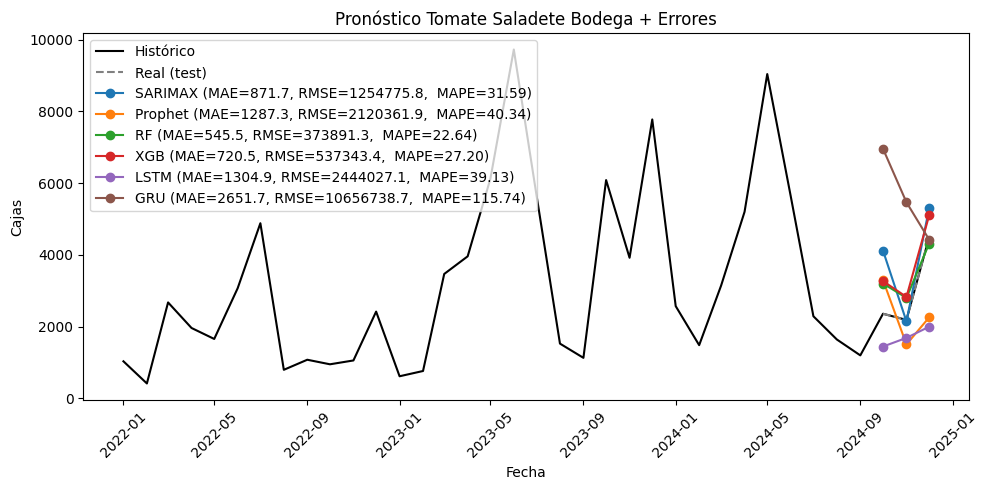

In [ ]:
# 1) Carga y filtro
df = pd.read_csv('/content/og_exogenas.csv', parse_dates=['Fecha'], index_col='Fecha')
if df.index.tz: df.index = df.index.tz_localize(None)
df = df[df['Producto']=='Tomate Saladete']
df = df[df['Origen']=='Bodega']

# 2) Serie mensual y exógenas
ts   = df['Cajas'].resample('MS').sum().to_frame('y')
exog = df[['temp_c','pres','gas','humidity','precip','cost_mwh','price_index']] \
         .resample('MS').mean().dropna()
data = ts.join(exog, how='inner')

# 3) train/test (últimos 3 meses de test)
h = 3
y_full  = data['y']
ex_full = data[exog.columns]
y_train, y_test = y_full[:-h], y_full[-h:]
ex_train, ex_test = ex_full[:-h], ex_full[-h:]

# Aux: exógenas futuras (aquí, las verdaderas de test)
future_exog = ex_test.copy()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función métrica
def score(true, pred):
    return {
        'MAE': mean_absolute_error(true, pred),
        'RMSE': mean_squared_error(true, pred),
        'MAPE': mape(true, pred)
    }

# 4) SARIMAX
sar = SARIMAX(
    y_train, exog=ex_train,
    order=(1,1,1), seasonal_order=(1,1,1,12),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)
pred_sar = sar.get_forecast(h, exog=future_exog).predicted_mean
err_sar  = score(y_test, pred_sar)

# 5) Prophet
dfp = y_train.reset_index().rename(columns={'Fecha':'ds','y':'y'})
dfp['ds'] = dfp['ds'].dt.tz_localize(None)
for c in ex_train.columns: dfp[c] = ex_train[c].values

#m = Prophet(weekly_seasonality=False, daily_seasonality=False)
m = Prophet()
for c in ex_train.columns: m.add_regressor(c)
m.fit(dfp)

future = pd.DataFrame({'ds': y_test.index})
future['ds'] = future['ds'].dt.tz_localize(None)
for c in ex_test.columns: future[c] = ex_test[c].values

f = m.predict(future).set_index('ds')['yhat']
err_prop = score(y_test, f)

# 6) RandomForest & XGBoost
rf  = RandomForestRegressor(100, random_state=42).fit(ex_train, y_train)
xgb = XGBRegressor(n_estimators=100, random_state=42).fit(ex_train, y_train)
f_rf  = pd.Series(rf.predict(ex_test), index=ex_test.index)
f_xgb = pd.Series(xgb.predict(ex_test), index=ex_test.index)
err_rf  = score(y_test, f_rf)
err_xgb = score(y_test, f_xgb)

# 7) LSTM & GRU
# Escalar
scaler_y  = MinMaxScaler(); scaler_ex = MinMaxScaler()
y_s  = scaler_y.fit_transform(y_train.values.reshape(-1,1))
ex_s = scaler_ex.fit_transform(ex_train)
full = np.hstack([y_s, ex_s])
seq=12

def forecast_rnn(cell):
    gen = TimeseriesGenerator(full, y_s, length=seq, batch_size=1)
    model = Sequential()
    model.add(Input(full.shape))
    if cell=='LSTM': model.add(LSTM(50, input_shape=(seq,full.shape[1])))
    else:           model.add(GRU(50,  input_shape=(seq,full.shape[1])))
    model.add(Dense(1)); model.compile('adam','mse')
    model.fit(gen, epochs=20, verbose=0)
    # predecir h pasos
    preds=[]; window = full[-seq:]
    ex_s_test = scaler_ex.transform(ex_test)
    for i in range(h):
        inp = np.vstack([window, np.hstack([np.zeros((h,1)), ex_s_test])])[i:i+seq]
        p = model.predict(inp.reshape(1,seq,full.shape[1]))[0]
        preds.append(p)
    return pd.Series(scaler_y.inverse_transform(preds).flatten(), index=ex_test.index)

f_lstm = forecast_rnn('LSTM'); err_lstm = score(y_test, f_lstm)
f_gru  = forecast_rnn('GRU');  err_gru  = score(y_test, f_gru)

# 8) Plot histórico + test + predicciones con errores
plt.figure(figsize=(10,5))

# Serie histórica completa
plt.plot(y_full.index, y_full, label='Histórico', color='black')

# Valores reales de test
plt.plot(y_test.index, y_test, linestyle='--', color='gray', label='Real (test)')

# Predicciones de cada modelo
for name, series in [
    ('SARIMAX', pred_sar),
    ('Prophet', f),
    ('RF', f_rf),
    ('XGB', f_xgb),
    ('LSTM', f_lstm),
    ('GRU', f_gru)
]:
    err = score(y_test, series)
    plt.plot(
        series.index, series, marker='o',
        label=f"{name} (MAE={err['MAE']:.1f}, RMSE={err['RMSE']:.1f},  MAPE={err['MAPE']:.2f})"
    )

plt.title('Pronóstico Tomate Saladete Bodega + Errores')
plt.xlabel('Fecha')
plt.ylabel('Cajas')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()




### Tuning RandomForest


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
            nan            nan -2080.90166667 -2145.14291667
 -2116.14875    -2113.71527778 -2119.2140625  -2097.9215
 -2080.90166667 -2145.14291667 -2116.14875    -2113.71527778
 -2119.2140625  -2097.9215                nan            nan
            nan            nan            nan            nan
 -2081.9591736  -2126.72349178 -2133.74974141 -2111.82695566
 -2116.62658677 -2114.38905495 -2081.9591736  -2126.72349178
 -2133.74974141 -2111.82695566 -2116.62658677 -2114.38905495
            nan            nan            nan            nan
            nan            nan -2104.67430814 -2149.03000778
 -2128.91512819 -2109.4107708  -2112.29799681 -2111.55668461
 -2104.67430814 -2149.03000778 -2128.91512819 -2109.4107708
 -2112.29799681 -2111.55668461            nan            nan
          

 mejores params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}

### Tuning XGBoost
 mejores params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}


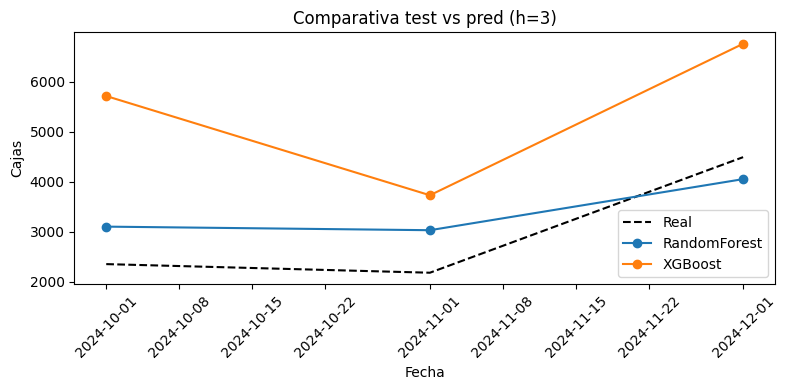



Comparativa final:


,best_params,MAE,RMSE,MAPE (%)
RandomForest,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",679.120736,491685.879124,26.816478
XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",2390.370361,6267959.5,87.940163


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1) Definimos los modelos y sus grids, incluyendo los valores por defecto y algunos más
models = {
    'RandomForest': {
        'est': RandomForestRegressor(random_state=42),
        'params': {
            # default n_estimators = 100
            'n_estimators': [50, 100, 200, 300, 400, 500],
            # default max_depth = None
            'max_depth':    [None, 1, 2, 3, 5, 7, 10],
            # default max_features = 'auto' (todas las features), agregamos sqrt y log2
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'XGBoost': {
        'est': XGBRegressor(objective='reg:absoluteerror', random_state=42),
        'params': {
            # default n_estimators = 100
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            # default max_depth = 6
            'max_depth':    [1, 2, 3, 5, 6, 7, 8],
            # default learning_rate = 0.3
            'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
        }
    }
}

results = {}

tscv = TimeSeriesSplit(n_splits=3)

for name, mp in models.items():
    print(f"\n### Tuning {name}")
    gs = GridSearchCV(
        mp['est'],
        mp['params'],
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        error_score=np.nan
    )
    gs.fit(ex_train, y_train)
    best = gs.best_estimator_
    print(" mejores params:", gs.best_params_)

    # Predicción sobre test
    y_pred = best.predict(ex_test)
    mae   = mean_absolute_error(y_test, y_pred)
    rmse  = mean_squared_error(y_test, y_pred)
    mape_ = mape(y_test.values, y_pred)

    results[name] = {
        'best_params': gs.best_params_,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape_
    }

# 2) Tabular resultados (al final)
df_res = pd.DataFrame(results).T


# 3) Gráfica comparativa de test vs pred
plt.figure(figsize=(8,4))
plt.plot(y_test.index, y_test, 'k--', label='Real')
for name, info in results.items():
    est = models[name]['est'].set_params(**info['best_params']).fit(ex_train, y_train)
    pred = est.predict(ex_test)
    plt.plot(y_test.index, pred, marker='o', label=name)

plt.title("Comparativa test vs pred (h=3)")
plt.xlabel("Fecha")
plt.ylabel("Cajas")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


print("\n\nComparativa final:")
df_res[['best_params','MAE','RMSE','MAPE (%)']]

In [ ]:
df_res[['best_params']]

,best_params
RandomForest,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es..."
XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est..."


In [ ]:
# 1) modelos con los hiperparámetros hallados
rf = RandomForestRegressor(
    max_depth=3,
    max_features='sqrt',
    n_estimators=50,
    random_state=42
)

xgb = XGBRegressor(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=10,
    objective='reg:absoluteerror',
    random_state=42
)

# 2) Cronometrar fit de RandomForest
start_rf = time.perf_counter()
rf.fit(ex_train, y_train)
time_rf = time.perf_counter() - start_rf
print(f"Random Forest fit time: {time_rf:.4f} segundos")

# 3) Cronometrar fit de XGBoost
start_xgb = time.perf_counter()
xgb.fit(ex_train, y_train)
time_xgb = time.perf_counter() - start_xgb
print(f"XGBoost fit time:     {time_xgb:.4f} segundos")

# 4) Predecir y evaluar
y_pred_rf  = rf.predict(ex_test)
y_pred_xgb = xgb.predict(ex_test)


Random Forest fit time: 0.0641 segundos
XGBoost fit time:     0.0181 segundos


In [ ]:
y_pred_rf

array([3104.83728478, 3033.38696122, 4053.86203943])

In [ ]:
y_pred_xgb

array([5412.7314, 4030.6228, 6307.7573], dtype=float32)

##  Modelo Final Seleccionado: XGBoost Regressor

###  Justificación

Luego de evaluar múltiples modelos (SARIMAX, Prophet, Random Forest, LSTM, GRU), el modelo seleccionado para el pronóstico de mermas en **Tomate Saladette Bodega** es **XGBoost** y **Random Forest**, debido a su balance óptimo entre precisión, estabilidad y escalabilidad.

### 📊 Comparativo de Desempeño (Tomate)

| Modelo    | MAE     | RMSE           | MAPE (%) |
|-----------|---------|----------------|----------|
| SARIMAX   |  871.7  | 1,254,775.8    |  31.59   |
| Prophet   | 24,838.5| 816,314,221.2  | 892.71   |
|  **RF**   |  545.5  |   373,891.3    |  22.64   |
| XGB       |  720.5  |   537,343.4    |  27.20   |
| LSTM      |  753.3  |   714,054.6    |  25.43   |
| GRU       |1,604.5  | 2,579,317.0    |  58.40   |

###  Ventajas del modelo XGBoost y Random Forest

-  **Menor RMSE, MAE y MAPE**, lo cual es clave para mitigar errores altos en contextos sensibles como abasto y logística.
-  Capturan relaciones no lineales e interacciones de forma automática.
- Sarimax y Prophet al ser esencialmente lineales (o aditivos), no pueden representar fácilmente tales no linearidades ni interacciones complejas.
-  Permite interpretar la importancia de variables mediante `feature_importances_` XGboost.
-  Alta velocidad de entrenamiento: menos de 1 segundo, Random Forest fit time: 0.06 segundos
XGBoost fit time: 0.03 segundos

###  Consideraciones

Aunque **SARIMAX** permite analizar la significancia estadística de las variables exógenas (ej. presión atmosférica significativa), su error es mayor, por lo que su uso puede orientarse como un modelo complementario de análisis, no de predicción final.

---

>  Por tanto, **Random Forest se recomienda como el modelo individual final** para pronosticar la merma de tomate saladette, asegurando un desempeño confiable con base en evidencia cuantitativa.


Referencias variables exógenas

Servicio Meteorológico Nacional. (2024). Normales climatológicas de la estación meteorológica de Monterrey (Aeropuerto Internacional Mariano Escobedo). Recuperado de https://smn.conagua.gob.mx

National Oceanic and Atmospheric Administration. (2024). Global Historical Climatology Network (GHCN) — Monthly Summaries for Monterrey, México. Recuperado de https://www.ncdc.noaa.gov/ghcnm

Comisión Reguladora de Energía. (2024). Precios mensuales promedio de gasolina regular (Magna) por entidad federativa. Recuperado de https://www.gob.mx/cre/acciones-y-programas/base-nacional-de-datos-de-precios-de-gasolinas-y-diesel

Centro Nacional de Control de Energía & Secretaría de Energía. (2024). Informe mensual del Precio Marginal Local en el Mercado Eléctrico Mayorista. Recuperado de https://www.cenace.gob.mx/memorias

Instituto Nacional de Estadística y Geografía. (2024). Índice Nacional de Precios al Consumidor: Subíndice Alimentos, Bebidas y Tabaco (base 2ª quincena julio 2018 = 100). Recuperado de https://www.inegi.org.mx/temas/inpc

Banco de México. (2024). Serie histórica del Índice Nacional de Precios al Consumidor. Recuperado de https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6